# Precipitation exercises
***

## <font color=steelblue>Exercise 5 - Intensity-duration-frequency curves

<font color=steelblue>Build an IDF (intensity-duration-frequency) curve from the data in table _ChiAnnMax_ in file _RainfallData.xlsx_.<tfont>

In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-whitegrid')

from scipy.stats import genextreme
from scipy.optimize import curve_fit

**Intensity-Duration-Frequency (IDF) curves** are a common approach for defining a design storm in a hydrologic project. IDF curves relate rainfall intensity, storm duration and frequency (expressed as return period).
 
<img src="img/IDF curves.JPG" alt="Mountain View" style="width:500px">

> <font color=gray>Intensity-duration-frequency curve for Oklahoma City (Applied Hydrology. Chow, 1988).</font>

When designing a structure, the objetive is to know the precipitation intensity given a return period and a duration. We would know the return period we want to design the structure for (usually defined by laws or standards). We would have to find the worst case scenario for the duration; this is usually the time of concentration of the structure's basin.

**Empirical IDF curves**
To build a IDF curve out of local data, we must carry out a frequency analysis. As input values, we need an annual series of maximum precipitation intensity for several storm durations. We must fit the series for each storm duration to a extreme values distributions in order to estimate the precipitation intensity given a return period. This is the **empirical IDF curve**.

**Analytical IDF curves**
Another way to create the IDF curve is to use **analytical IDF curves**. In this case we don't need to carry out the frequency analysis, but we must fit the analytical IDF curve to the observations. Once we've fitted the curve parameters, we can plot the IDF curves.

### Import data

To build inensity-duration-frequency curves we need series of annual maximum intensity aggregated at different storm durations (in our case 1, 6 and 24 h).

In [2]:
# load precipitation intensity data
intensity = pd.read_excel('../data/RainfallData.xlsx', sheet_name='ChiAnnMax', skiprows=7,
                          usecols=[0, 5, 6, 7], index_col='Year')
# convert inches to mm
intensity = intensity * 25.4
# change column names to storm duration
D = np.array([1, 6 , 24]) # storm duration
intensity.columns = D
intensity.head()

,1,6,24
Year,,,
1949,20.066,6.688667,2.889250
1950,42.926,10.583333,3.714750
1951,38.100,9.101667,3.090333
1952,30.226,6.773333,1.693333
1953,25.908,10.244667,2.561167


In the following plot, we sort the maximum rainfall intensity series for each duration and plot it. 

We observe that the shorter the duration of a storm, the higher the intensity. Furthermore, we can also infer a higher variability (represented by the slope) with shorter storm duration.

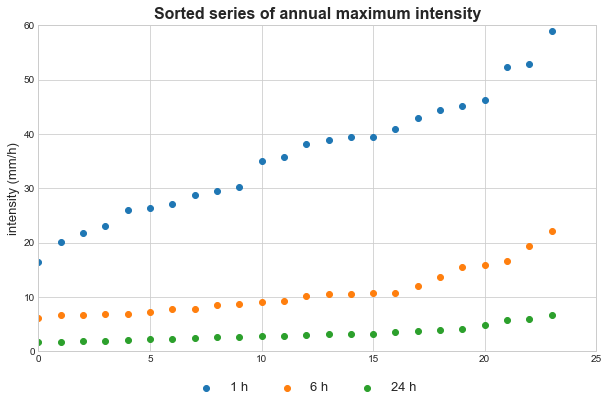

In [3]:
# set the plot
fig = plt.figure(figsize=(10, 6))
plt.title('Sorted series of annual maximum intensity', fontsize=16, weight='bold')
plt.xlabel('', fontsize=13)
plt.xlim((0, 25))
plt.ylabel('intensity (mm/h)', fontsize=13)
plt.ylim((0, 60))

# 3 scatter plots for each storm duration
plt.scatter(range(intensity.shape[0]), intensity.sort_values(1)[1], label='1 h')
plt.scatter(range(intensity.shape[0]), intensity.sort_values(6)[6], label='6 h')
plt.scatter(range(intensity.shape[0]), intensity.sort_values(24)[24], label='24 h')

# Legend
fig.legend(loc=8, ncol= 3, fontsize=13);

### Fit a GEV distribution to the data

We must fit a extreme values distribution to the data. From the fitted distribution, we will be able to estimate the intensity for any return period.

We will use the **GEV distribution (generalized extreme values)**. When applied to exclusively positive values such as precipitation, the GEV distribution is:

$$F(s,\xi)=e^{-(1+\xi s)^{-1/\xi}}  \quad \forall \xi>0$$
$$ s = \frac{x-\mu}{\sigma} \quad \sigma>0$$

Where $s$ is the study variable standardised by the location parameter $\mu$ and the scale parameter $\sigma$, and $\xi$ is the shape parameter. So the GEV distribution has three parameters to be fitted.

<img src="img/Frechet.png" alt="Mountain View" style="width:600px">

> <font color=grey>Density function and the cumulative density function of the GEV type II (Frechet distribution) for several values of scale and shape.</font><br>

To fit the GEV distribution, we will use the function `genextreme.fit`in the package `SciPy`. The output of this function are the values of the three GEV parameters (shape, location and scale) that better fit the input data.

In [4]:
# Example
# fit a GEV to the 1h-duration storm
par_int1h = genextreme.fit(intensity[1])

In [5]:
print('Fitted parameters for the intensity in 1h-duration storms:')
print('xi =', round(par_int1h[0], 4))
print('mu =', round(par_int1h[1], 4))
print('sigma =', round(par_int1h[2], 4))

Fitted parameters for the intensity in 1h-duration storms:
xi = 0.2339
mu = 31.7407
sigma = 10.3977


We'll repeat the process in a loop for all the storm durations (1, 6 and 24 h). We'll save the results in a data frame called _parameters_.

In [6]:
# fit parameters for the 3 durations
parameters = pd.DataFrame(index=['xi', 'mu', 'sigma'], columns=D)
for duration in D:
    # Ajustar la GEV y guardar los parámetros
    parameters[duration] = genextreme.fit(intensity[duration])
parameters

,1,6,24
xi,0.233923,-0.396873,-0.235411
mu,31.740658,8.404498,2.540506
sigma,10.397701,2.320138,0.836714


### Empirical IDF

The **non-exceedance probability** (i.e., the value of the cumulative density function) and the **return period** are related by the equation: 

\\[R = \frac{1}{1-CDF(x)}\\]

Where $R$ is the return period and $CDF(x)$ the cumulative density function (or non-exceedance probability) for a precipitation of $x$.

From this expression, we can estimate the **non-exceedance probability** of a fiven **return period**:

\\[CDF(x) = \frac{R-1}{R} = 1 - \frac{1}{R}\\]

We will analyse 10, 25, 50 and 100 years return periods. We'll estimete the quantiles (Q) corresponding to these return periods according to the previously fitted distributions.

In [7]:
# return periods
R = np.array([10, 25, 50, 100], dtype="float64")

In [8]:
# non-exceedance probability
Q = 1. - 1. / R

As an example, we will generate extreme values for a 1-h storm and the non-exceedance probabilities Q. We'll use function `genextrem`in the package `SciPy`.

In [9]:
# extreme values of intensity for a 1-h storm
P1 = genextreme.ppf(Q, *parameters[1]) # ppf: percent point function

print('Rainfall intensity in 1 h storms at different return perios:')
for i, Tr in enumerate(R):
     print('I(Tr=', int(Tr), ') = ', round(P1[i], 1), ' mm/h', sep='')


Rainfall intensity in 1 h storms at different return perios:
I(Tr=10) = 49.9 mm/h
I(Tr=25) = 55.2 mm/h
I(Tr=50) = 58.3 mm/h
I(Tr=100) = 61.0 mm/h


We can iterate the procedure across duration and return periods. Results will be saved in a *data frame* so that we can plot them afterwards.

In [10]:
# data frame with values of the IDF curve
IDFe = pd.DataFrame(index=R, columns=D)
IDFe.index.name = 'Tr'
for duration in D:
    IDFe[duration] = genextreme(*parameters[duration]).ppf(Q)
IDFe

,1,6,24
Tr,,,
10.0,49.932830,16.838676,5.023257
25.0,55.155961,23.363122,6.533005
50.0,58.347192,30.062678,7.892088
100.0,61.035854,38.844762,9.483084


In [11]:
# save results
IDFe.to_csv('../output/Ex5_Results empirical IDF.csv', float_format='%.1f')

Line plot that shows, for each return period, rainfall intensity as a function of storm duration.

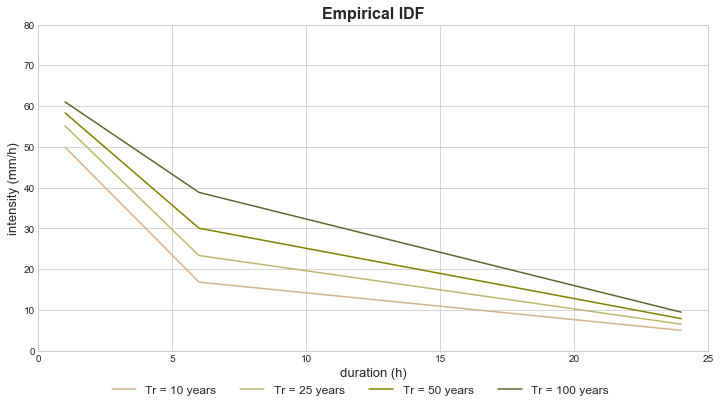

In [12]:
# configuración del gráfico
fig = plt.figure(figsize=(12, 6))
plt.title('Empirical IDF', fontsize=16, weight='bold')
plt.xlabel('duration (h)', fontsize=13)
plt.xlim(0, IDFe.columns.max() + 1)
plt.ylabel('intensity (mm/h)', fontsize=13)
plt.ylim((0, 80))
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

for i, Tr in enumerate(IDFe.index):
    plt.plot(IDFe.loc[Tr,:], color=color[i], label='Tr = ' + str(int(Tr)) + ' years')

fig.legend(loc=8, ncol=4, fontsize=12);

# guardar la figura
plt.savefig('../output/Ex5_empirical IDFs.png', dpi=300)

Since we have calculated three points for each of the curves, corresponding to the three durations, the curves are not smooth and unsuitable for interpolation. This is the reason why we need analytical IDF curves.

### Analytical IDF curves

Up to now, we have calculated 12 points of the IDF curves, those corresponding to the storms of 1, 6 and 24 h duration and the return periods of 10, 25, 50 and 100 years. Obtaining a smooth curve would require to iterate the procedure for many more durations. To avoid that, there exist analytical forms of the IDF curve. These equations take several forms:

\\[I = \frac{a}{(D + c)^b}\\]

\\[I = \frac{a}{D ^b + c}\\]

where \\(I\\) is the precipitation intensity, \\(D\\) storm duration , \\(a\\) is a constant dependent on the return period,and \\(b\\) and \\(c\\) are constants related to the study location.

We'll assume the following linear relation between $a$ and the return period:

\\[a = d \cdot R + e\\]

In [13]:
def IDF_type_I(x, b, c, d, e):
    """Estimate precipitation intensity fiven a return period and a storm duration using the analytical IDF curve type I:
    
    I = d * R + e / (D + c)**b.    
    
    Input:
    ------
    x:         list [2x1]. Values of return period (years) and duration (h)
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    e:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    a = d * x[0] + e
    I = a / (x[1] + c)**b
    return I

def IDF_type_II(x, b, c, d, e):
    """Estimate precipitation intensity fiven a return period and a storm duration using the analytical IDF curve type II:
    
    I = d * R + e / (D**b + c).    
    
    Input:
    ------
    x:         list [2x1]. Values of return period (years) and duration (h)
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    e:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    a = d * x[0] + e
    I = a / (x[1]**b + c)
    return I

def IDF_type_III(x, b, c, d, e):
    """Estimate precipitation intensity fiven a return period and a storm duration using the analytical IDF curve type III:
    
    I = d * R**e / (D + c)**b.    
    
    Input:
    ------
    x:         list [2x1]. Values of return period (years) and duration (h)
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    e:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    a = d * x[0]**e 
    I = a / (x[1] + c)**b
    return I

def IDF_type_IV(x, b, c, d, e):
    """Estimate precipitation intensity fiven a return period and a storm duration using the analytical IDF curve type IV:
    
    I = d * R**e / (D**b + c).    
    
    Input:
    ------
    x:         list [2x1]. Values of return period (years) and duration (h)
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    e:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    a = d * x[0]**e
    I = a / (x[1]**b + c)
    return I 

We must first create a grid with values of return period and duration. We will use the three storm durations and the four return periods for which we have already estimated precipitation intensity.

We will apply function `curve_fit` in package `SciPy`to fit the parameters of the analytical IDF curve. Inputs are the function to be fitted (*curve*), an array with pairs of values of return period and duration (*XX*), and the value of intensity at those pairs (*I*).

In [14]:
# grid with all possible combinations of duration and return period
(RR, DD) = np.meshgrid(R, D)
RR.shape, DD.shape

((3, 4), (3, 4))

In [15]:
# convert the grid ('RR' and 'DD') into a 1D array
RR = RR.reshape(-1)
DD = DD.reshape(-1)
RR.shape, DD.shape

((12,), (12,))

In [16]:
# join 'RR' and 'DD' as columns of a 2D array
RD = np.vstack([RR, DD])
RD.shape

(2, 12)

In [17]:
# 1D array of intensity for each pair of values in 'XX'
I = np.hstack([IDFe[1], IDFe[6], IDFe[24]])
I.shape

(12,)

Para ajustar la curva utilizaremos la función `curve_fit` de `SciPy.optimize`. A esta función hemos de asignarle la función de la curva a ajustar, los valores de entrada (pares retorno-duración) y el valor de la función en esos pares (intensidad). La función devuelve un vector con los parámetros de la curva optimizados y otro vector con las covarianza entre dichos parámetros

In [18]:
# fit the curve
curve = IDF_type_IV
popt, pcov = curve_fit(curve, RD, I)

print('Fitted parameters of the analytical IDF')
for i, par in enumerate(['b', 'c', 'd', 'e']):
    print(par, '=', round(popt[i], 4))

Fitted parameters of the analytical IDF
b = 1.2978
c = 8.1883
d = 311.246
e = 0.1403


In [19]:
# save the optimized parameters
IDFa = pd.DataFrame(popt, index=['b', 'c', 'd', 'e']).transpose()
IDFa.to_csv('../output/Ex5_Parameters analytical IDF.csv', float_format='%.5f')

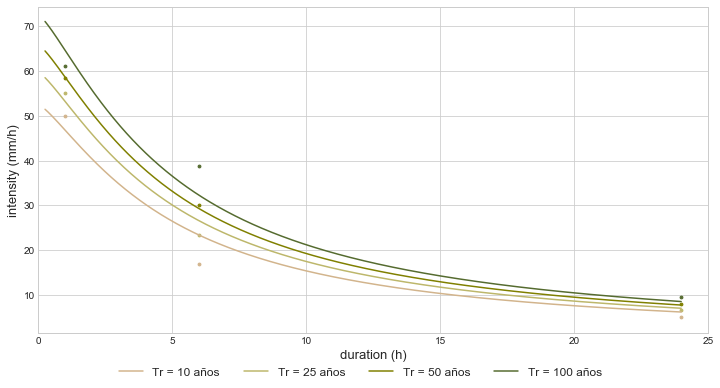

In [20]:
# plot the analytical IDF curves
fig = plt.figure(figsize=(12, 6))
plt.xlim(0, D.max()+1)
plt.xlabel('duration (h)', fontsize=13)
plt.ylabel('intensity (mm/h)', fontsize=13)
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

xx = np.linspace(.25, D.max(), 1000) # duration values
y = np.zeros((xx.size,)) # empty array with values of intensity

for i, Tr in enumerate(R): # for each return period
    for j, d in enumerate(xx): # for each duration
        y[j] = curve((Tr, d), *popt)
    # lineplot
    plt.plot(xx, y, color=color[i], label='Tr = ' + str(int(Tr)) + ' años')
    # scatter plot
    plt.scatter(D, IDFe.loc[Tr], s=8, marker='o', c=color[i], label=None)

fig.legend(loc=8, ncol=4, fontsize=12);

# save figure
plt.savefig('../output/Ex5_analytical IDFs.png', dpi=300)